In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
from pathlib import Path
import fiona 
import numpy as np
import pandas as pd
import logging
# Plotting
import matplotlib.pyplot as plt
# Pour la basemap
import contextily as cx
# Potentiel solaire package

In [3]:

from potentiel_solaire.attach_buildings_to_schools import attach_buildings_to_schools
from potentiel_solaire.constants import DATA_FOLDER
from potentiel_solaire.constants import CRS, ALGORITHME_FOLDER, DATA_FOLDER
from potentiel_solaire.sources.bd_topo import extract_bd_topo, get_topo_zones_of_interest, \
    get_topo_buildings_of_interest
from potentiel_solaire.sources.bd_pci import extract_bd_pci
from potentiel_solaire.sources.bd_solar_irradiation import extract_bd_irradiation
from potentiel_solaire.sources.schools_establishments import extract_schools_establishments, \
    get_schools_establishments_of_interest
from potentiel_solaire.features.solar_potential import calculate_solar_potential
from potentiel_solaire.aggregate import aggregate_solar_potential_by
from potentiel_solaire.logger import get_logger

logger = get_logger() 
logger.setLevel(logging.ERROR)

In [4]:
code_departement = "093"
compare_with_idf = True

# Imports & setup

/tmp/ipykernel_6195/2162312035.py:4: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  dpts[dpts.code == "93"].plot(column="nom",legend=True, categorical = True, ax = ax, color="green",alpha=0.5)
/tmp/ipykernel_6195/2162312035.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


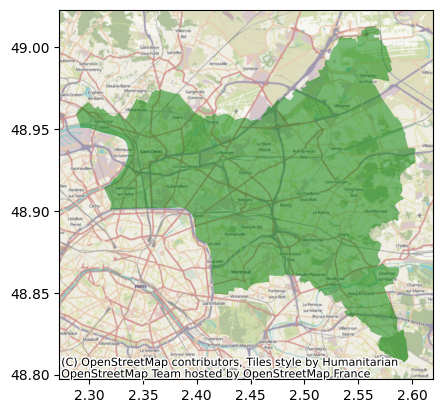

In [5]:
dpts = gpd.read_file(DATA_FOLDER / "contour-des-departements.geojson").to_crs(4326)
ShapeNT = dpts[dpts.code == "93"].geometry
fig, ax = plt.subplots()
dpts[dpts.code == "93"].plot(column="nom",legend=True, categorical = True, ax = ax, color="green",alpha=0.5)
cx.add_basemap(ax, crs=dpts.crs)
fig.show()

In [6]:
schools_establishments_path = extract_schools_establishments()
bd_topo_path = extract_bd_topo(code_departement=code_departement)
bd_pci_path = extract_bd_pci(code_departement=code_departement)

In [7]:
schools_establishments = get_schools_establishments_of_interest(
    schools_filepath=schools_establishments_path,
    code_departement=code_departement,
    types_etablissements=['Ecole', 'Lycée', 'Collège'],
    statut_public_prive="Public",
    etat="OUVERT",
    crs=CRS
)
nb_schools = schools_establishments.shape[0]
print(f"Nb d'établissements scolaires: {nb_schools}")


Nb d'établissements scolaires: 1130


In [8]:
educational_zones = get_topo_zones_of_interest(
    bd_topo_path=bd_topo_path,
    geom_of_interest=ShapeNT,
    categories=["Science et enseignement"],
    natures=['Collège', 'Lycée', 'Enseignement primaire'],
    crs=CRS
)
nb_educational_zones = educational_zones.shape[0]
print("Nb de zones d'éducations: ", nb_educational_zones)

/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying(256)' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying(30)' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'timestamp with time zone' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/geopandas/io/file.py:497: UserWarning: More than one layer found in 'BDT_3-4_GPKG_LAMB93_D093-ED2024-12-15.gpkg': 'troncon

Nb de zones d'éducations:  1090


In [9]:
educational_zones

,cleabs,categorie,nature,nature_detaillee,toponyme,statut_du_toponyme,importance,fictif,etat_de_l_objet,date_creation,date_modification,date_d_apparition,date_de_confirmation,sources,identifiants_sources,methode_d_acquisition_planimetrique,precision_planimetrique,identifiant_voie_ban,nom_commercial,geometry
28,SURFACTI0000000245754384,Science et enseignement,Enseignement primaire,Ecole maternelle,École Maternelle Julie Daubie,Collecté,5,True,En service,2010-12-02 16:57:30.930,2024-06-26 17:22:39.129,NaT,2024-04-09,MEN 2024,MEN:0930498L,Calculé,20.0,None,None,"MULTIPOLYGON (((2.42228 48.88384, 2.42222 48.8..."
38,SURFACTI0000000002556043,Science et enseignement,Enseignement primaire,Ecole élémentaire,École Élémentaire Eugénie Cotton,Collecté,5,False,En service,2006-05-22 16:31:28.175,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0931245Y,BDTopo,2.5,None,None,"MULTIPOLYGON (((2.42516 48.87474, 2.42521 48.8..."
39,SURFACTI0000000002556011,Science et enseignement,Enseignement primaire,Ecole élémentaire,École Élémentaire Notre-Dame,Collecté,5,False,En service,2006-05-22 16:31:28.175,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0931116H,BDTopo,2.5,None,None,"MULTIPOLYGON (((2.41429 48.87978, 2.41437 48.8..."
40,SURFACTI0000000245754375,Science et enseignement,Collège,None,Collège Travail Langevin,Collecté,5,False,En service,2010-12-02 16:56:34.396,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0931220W,BDTopo,2.5,None,None,"MULTIPOLYGON (((2.42386 48.87458, 2.42406 48.8..."
41,SURFACTI0000002009935688,Science et enseignement,Enseignement primaire,Ecole élémentaire,École Élémentaire Romain Rolland,Collecté,5,True,En service,2018-04-05 17:27:59.901,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0930368V,Calculé,20.0,None,None,"MULTIPOLYGON (((2.41822 48.87946, 2.41815 48.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3765,SURFACTI0000002008886034,Science et enseignement,Enseignement primaire,Ecole élémentaire,École Élémentaire Louis Eugène Varlin I,Collecté,5,False,En service,2018-02-19 17:17:07.177,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0932709P/MEN:0930329C,Image satellite,10.0,None,None,"MULTIPOLYGON (((2.36864 48.97131, 2.36818 48.9..."
3768,SURFACTI0000002244322967,Science et enseignement,Enseignement primaire,Ecole élémentaire,École Élémentaire Jean Mermoz 2,Collecté,5,False,En service,2021-06-08 14:53:04.277,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0950114H,Orthophotographie,3.0,None,None,"MULTIPOLYGON (((2.37248 48.97276, 2.3724 48.97..."
3769,SURFACTI0000002244322966,Science et enseignement,Enseignement primaire,Ecole maternelle,École Maternelle Jean Mermoz,Collecté,5,False,En service,2021-06-08 14:53:04.277,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0950618F,Orthophotographie,3.0,None,None,"MULTIPOLYGON (((2.37269 48.97311, 2.37252 48.9..."
3770,SURFACTI0000000351259121,Science et enseignement,Enseignement primaire,Ecole élémentaire,École Élémentaire Danielle Mitterrand,Collecté,5,False,En service,2015-06-05 11:40:57.814,2024-06-26 15:11:41.545,NaT,2024-04-09,MEN 2024,MEN:0932594P,Orthophotographie,3.0,None,None,"MULTIPOLYGON (((2.36683 48.97261, 2.36723 48.9..."


In [ ]:
def find_all_intersections(gdf):
    # Perform spatial join on the GeoDataFrame with itself
    joined = gpd.sjoin(gdf, gdf, how="inner", predicate="intersects")

    # Filter out self-joins
    joined = joined[joined.index != joined.index_right]

    # Create pairs of indices
    pairs = list(zip(joined.index, joined.index_right))

    # Remove duplicate pairs (i.e., (1,2) and (2,1))
    unique_pairs = set()
    for a, b in pairs:
        unique_pairs.add(tuple(sorted([a, b])))

    return list(unique_pairs)

In [17]:
intsct = find_all_intersections(educational_zones) 

In [20]:
zns = []
for x in intsct:
    zns.append(x[0])
    zns.append(x[1])
n = list(set(zns))
len(n)

616

In [10]:
# TODO : ajout des batiments manquants avec la BD PCI
buildings = get_topo_buildings_of_interest(
    bd_topo_path=bd_topo_path,
    geom_of_interest=ShapeNT,
    crs=CRS
)
nb_buildings = buildings.shape[0]
print("Nb de batiments: ", nb_buildings)

/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying(256)' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'character varying(30)' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/pyogrio/core.py:279: RuntimeWarning: Field format 'timestamp with time zone' not supported
  return ogr_read_info(
/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/geopandas/io/file.py:497: UserWarning: More than one layer found in 'BDT_3-4_GPKG_LAMB93_D093-ED2024-12-15.gpkg': 'troncon

Nb de batiments:  351632


In [11]:
recollement = gpd.sjoin_nearest(schools_establishments, educational_zones, distance_col="distances", lsuffix="e_", rsuffix="f_", exclusive=True)
recollement.head(3)

/home/kelu/projets/13_potentiel_solaire/algorithme/.venv/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,identifiant_de_l_etablissement,nom_etablissement,type_etablissement,statut_public_prive,adresse_1,adresse_2,adresse_3,code_postal,code_commune,nom_commune,...,date_modification,date_d_apparition,date_de_confirmation,sources,identifiants_sources,methode_d_acquisition_planimetrique,precision_planimetrique,identifiant_voie_ban,nom_commercial,distances
63,0932595R,Ecole primaire La Roseraie - Jacqueline de Cha...,Ecole,Public,47 rue Pinel,None,93200 ST DENIS,93200,93066,Saint-Denis,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0932595R,Orthophotographie,3.0,None,None,0.0
8972,0930145C,Ecole élémentaire Anatole France,Ecole,Public,68 rue Anatole France,None,93120 LA COURNEUVE,93120,93027,La Courneuve,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0930406L/MEN:0930145C,BDTopo,2.5,None,None,0.0
8973,0930150H,Ecole élémentaire Victor Hugo,Ecole,Public,8 rue Jean Mermoz,None,93200 ST DENIS,93200,93066,Saint-Denis,...,2024-10-14 13:05:52.604,NaT,2024-04-09,MEN 2024,MEN:0930150H,BDTopo,2.5,None,None,0.0


In [12]:
recollement

,identifiant_de_l_etablissement,nom_etablissement,type_etablissement,statut_public_prive,adresse_1,adresse_2,adresse_3,code_postal,code_commune,nom_commune,...,date_modification,date_d_apparition,date_de_confirmation,sources,identifiants_sources,methode_d_acquisition_planimetrique,precision_planimetrique,identifiant_voie_ban,nom_commercial,distances
63,0932595R,Ecole primaire La Roseraie - Jacqueline de Cha...,Ecole,Public,47 rue Pinel,None,93200 ST DENIS,93200,93066,Saint-Denis,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0932595R,Orthophotographie,3.0,None,None,0.000000
8972,0930145C,Ecole élémentaire Anatole France,Ecole,Public,68 rue Anatole France,None,93120 LA COURNEUVE,93120,93027,La Courneuve,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0930406L/MEN:0930145C,BDTopo,2.5,None,None,0.000000
8973,0930150H,Ecole élémentaire Victor Hugo,Ecole,Public,8 rue Jean Mermoz,None,93200 ST DENIS,93200,93066,Saint-Denis,...,2024-10-14 13:05:52.604,NaT,2024-04-09,MEN 2024,MEN:0930150H,BDTopo,2.5,None,None,0.000000
8974,0930154M,Ecole élémentaire Foch 1,Ecole,Public,73 rue Bernard Gante,None,93250 VILLEMOMBLE,93250,93077,Villemomble,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0930154M,BDParcellaire recalée,3.0,None,None,0.000001
8975,0930194F,Ecole élémentaire Jean Macé,Ecole,Public,46 rue Henri Barbusse,None,93300 AUBERVILLIERS,93300,93001,Aubervilliers,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0930194F,Orthophotographie,3.0,None,None,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68491,0931733D,Section d'enseignement général et professionne...,Collège,Public,66 BIS ROUTE D'AULNAY,None,93140 BONDY,93140,93010,Bondy,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0931733D/MEN:0931612X/MEN:0931612X,BDTopo,2.5,None,None,0.000184
68492,0931736G,Section d'enseignement professionnel du Lycée ...,Lycée,Public,152 RUE DURAND,None,93240 STAINS,93240,93072,Stains,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0932030B/MEN:0931736G,BDTopo,2.5,None,None,0.000137
68493,0931740L,Section d'enseignement professionnel du Lycée ...,Lycée,Public,2 RUE COMPAGNON,None,93140 BONDY,93140,93010,Bondy,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0931740L/MEN:0932282A,BDParcellaire recalée,3.0,None,None,0.000005
68494,0932128H,Section d'enseignement général et professionne...,Collège,Public,52 rue Jules Ferry,None,93170 BAGNOLET,93170,93006,Bagnolet,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0931181D,BDTopo,2.5,None,None,0.000000


8.369593065080684e-05


<Axes: >

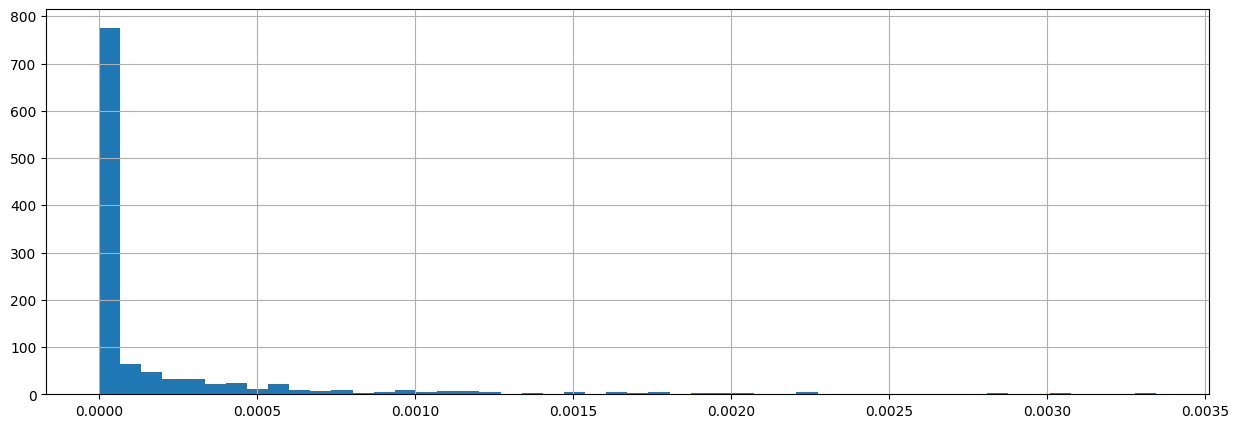

In [13]:
seuil_recol = recollement.distances.quantile(q=0.7)
print(seuil_recol)
recollement.distances.hist(bins=50,figsize=(15,5))

In [14]:
recollement[recollement.distances < 0.0001]

,identifiant_de_l_etablissement,nom_etablissement,type_etablissement,statut_public_prive,adresse_1,adresse_2,adresse_3,code_postal,code_commune,nom_commune,...,date_modification,date_d_apparition,date_de_confirmation,sources,identifiants_sources,methode_d_acquisition_planimetrique,precision_planimetrique,identifiant_voie_ban,nom_commercial,distances
63,0932595R,Ecole primaire La Roseraie - Jacqueline de Cha...,Ecole,Public,47 rue Pinel,None,93200 ST DENIS,93200,93066,Saint-Denis,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0932595R,Orthophotographie,3.0,None,None,0.000000
8972,0930145C,Ecole élémentaire Anatole France,Ecole,Public,68 rue Anatole France,None,93120 LA COURNEUVE,93120,93027,La Courneuve,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0930406L/MEN:0930145C,BDTopo,2.5,None,None,0.000000
8973,0930150H,Ecole élémentaire Victor Hugo,Ecole,Public,8 rue Jean Mermoz,None,93200 ST DENIS,93200,93066,Saint-Denis,...,2024-10-14 13:05:52.604,NaT,2024-04-09,MEN 2024,MEN:0930150H,BDTopo,2.5,None,None,0.000000
8974,0930154M,Ecole élémentaire Foch 1,Ecole,Public,73 rue Bernard Gante,None,93250 VILLEMOMBLE,93250,93077,Villemomble,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0930154M,BDParcellaire recalée,3.0,None,None,0.000001
8975,0930194F,Ecole élémentaire Jean Macé,Ecole,Public,46 rue Henri Barbusse,None,93300 AUBERVILLIERS,93300,93001,Aubervilliers,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0930194F,Orthophotographie,3.0,None,None,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68489,0931442M,Section d'enseignement général et professionne...,Collège,Public,17 rue François Mitterrand,None,93380 PIERREFITTE SUR SEINE,93380,93059,Pierrefitte-sur-Seine,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0931223Z,BDTopo,2.5,None,None,0.000073
68490,0931543X,Section d'enseignement général et professionne...,Collège,Public,17 RUE DES HULEUX,None,93240 STAINS,93240,93072,Stains,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0931543X/MEN:0931226C,BDTopo,2.5,None,None,0.000000
68493,0931740L,Section d'enseignement professionnel du Lycée ...,Lycée,Public,2 RUE COMPAGNON,None,93140 BONDY,93140,93010,Bondy,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0931740L/MEN:0932282A,BDParcellaire recalée,3.0,None,None,0.000005
68494,0932128H,Section d'enseignement général et professionne...,Collège,Public,52 rue Jules Ferry,None,93170 BAGNOLET,93170,93006,Bagnolet,...,2024-04-17 14:57:25.903,NaT,2024-04-09,MEN 2024,MEN:0931181D,BDTopo,2.5,None,None,0.000000


In [15]:
# @TODO: garder 80% des recollements
# @TODO revoir adresses
# @TODO revoir numéros établissements mere
# @TODO garder les batiments qui ont au moins 70% dans la zone
